# Landuse machine learning model -test-

This notebook integrates the first steps towards the development of a machine learning model for urban landuse prediction.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import aup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA



from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation  
from sklearn.preprocessing import LabelEncoder
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import utils  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,confusion_matrix

2025-07-22 12:57:29.246535: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 12:57:29.252904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753210649.259789  172624 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753210649.261889  172624 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753210649.267633  172624 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data for model training

In [2]:
gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_primera_pred.gpkg')
print(gdf.shape)
gdf.head(2)

(88061, 75)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,pct_smote_comercio,pct_smote_equipamiento,pct_smote_espacio_verde,pct_smote_habitacional,pct_smote_industria,pct_smote_infraestructura,pct_smote_mixto,pct_smote_servicio,pct_smote_sin_dato,geometry
0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,0,...,3.705982e-09,1.238207e-11,1.459788e-11,7.209011e-07,4.337737e-12,0.0,4.721963e-22,1.322631e-07,0.999997,"MULTIPOLYGON (((2349152.724 965335.704, 234914..."
1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,0,...,1.188032e-08,1.260674e-10,7.887108e-11,2.782248e-06,3.838243e-11,0.0,1.907046e-19,3.001367e-07,0.999992,"MULTIPOLYGON (((2349168.91 965335.176, 2349157..."


In [3]:
if 'fid' not in gdf.columns:
    gdf = gdf.reset_index().rename(columns={'index':'fid'})

In [4]:
gdf.columns

Index(['fid', 'uso_suelo', 'area_m2', 'full_plus_code', 'CVEGEO',
       'bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct', 'pobtot', 'cultural_recreativo', 'servicios',
       'comercio', 'salud', 'educacion', 'gobierno', 'industria',
       'area_m2_tot', 'habitacional', 'uso_tot', 'pct_habitacional',
       'pct_cultural_recreativo', 'pct_servicios', 'pct_comercio', 'pct_salud',
       'pct_educacion', 'pct_gobierno', 'pct_industria',
       'temperature_mean_diff', 'ndvi_mean', 'ndmi_diff', 'tertiary_distance',
       'residential_distance', 'secondary_distance', 'footway_distance',
       'path_distance', 'service_distance', 'living_street_distance',
       'primary_distance', 'trunk_distance', 'pedestrian_distance',
       'cycleway_distance', 'unclassified_distance', 'motorway_distance',
       'steps_distance', 'denue_primaria', 'denue_primaria_15min',
       'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
       'denue_

## Machine learning model

### Data preprocessing

Divide X and Y data

In [5]:
X = gdf[['area_m2','bld_area_m2','block_area_m2',
    'pred_area_m2', 'pred_area_pct', 'bld_pred_area_pct',
    'uso_tot','pobtot','pct_habitacional', 'pct_cultural_recreativo',
    'pct_servicios', 'pct_comercio', 'pct_salud', 'pct_educacion',
    'pct_gobierno', 'pct_industria',
    'temperature_mean_diff','ndvi_mean','ndmi_diff',
    'tertiary_distance','residential_distance', 'secondary_distance', 
    'footway_distance','path_distance', 'service_distance',
    'living_street_distance','primary_distance', 'trunk_distance', 
    'pedestrian_distance','cycleway_distance', 'unclassified_distance', 
    'motorway_distance','steps_distance',
    'denue_primaria', 'denue_primaria_15min',
    'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
    'denue_peluqueria_15min', 'denue_lavanderia', 'denue_lavanderia_15min',
    'clues_primer_nivel', 'clues_primer_nivel_15min',
    'pct_alojamiento_temporal', 'pct_baldio', 'pct_equipamiento',
   'pct_espacio_verde', 'pct_infraestructura', 'pct_mixto', 'pct_servicio',
   'pct_sin_dato', 'pct_smote_alojamiento_temporal', 'pct_smote_baldio',
   'pct_smote_comercio', 'pct_smote_equipamiento',
   'pct_smote_espacio_verde', 'pct_smote_habitacional',
   'pct_smote_industria', 'pct_smote_infraestructura', 'pct_smote_mixto',
   'pct_smote_servicio', 'pct_smote_sin_dato'
    ]].to_numpy()

Y = gdf[['uso_suelo']].to_numpy()
Y = np.reshape(Y, shape=(Y.shape[0],))

Standarize and encode data

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Divide training, validation and testing data

In [7]:
X_model, X_test, y_model, y_test = (train_test_split(X_scaled, encoded_Y, test_size=0.2, random_state=0))

In [8]:
smote = SMOTE()  
X_resampled, y_resampled = smote.fit_resample(X_model, y_model)  

In [9]:
X_train, X_val, y_train, y_val = (train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0))
# X_train, X_val, y_train, y_val = (train_test_split(X_model, y_model, test_size=0.2, random_state=0))

Y data to categorical

In [10]:
# encode class values as integers
num_classes = len(gdf.uso_suelo.unique())

# convert integers to dummy variables (i.e. one hot encoded)
y_train = utils.to_categorical(y_train, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_val = utils.to_categorical(y_val, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_test = utils.to_categorical(y_test, num_classes)

### Model construction -- Classification Neural network

Model parameters

In [11]:
input_shape = (X_train.shape[1],)

In [12]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())
    

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753210662.103951  172624 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4588 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,907 (34.79 KB)

 Trainable params: 8,907 (34.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model training

In [13]:
### Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, y_val)
                   )

Epoch 1/200


I0000 00:00:1753210664.726133  173204 service.cc:152] XLA service 0x7f392800b3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753210664.726147  173204 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-07-22 12:57:44.737835: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753210664.797655  173204 cuda_dnn.cc:529] Loaded cuDNN version 90300


  290/14792 ━━━━━━━━━━━━━━━━━━━━ 7s 523us/step - acc: 0.4941 - loss: 1.7153

I0000 00:00:1753210665.412940  173204 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14792/14792 ━━━━━━━━━━━━━━━━━━━━ 11s 705us/step - acc: 0.8389 - loss: 0.5144 - val_acc: 0.8868 - val_loss: 0.3181
Epoch 2/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 595us/step - acc: 0.8790 - loss: 0.3533 - val_acc: 0.8949 - val_loss: 0.2934
Epoch 3/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 585us/step - acc: 0.8838 - loss: 0.3350 - val_acc: 0.9005 - val_loss: 0.2793
Epoch 4/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 583us/step - acc: 0.8886 - loss: 0.3197 - val_acc: 0.9040 - val_loss: 0.2692
Epoch 5/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 577us/step - acc: 0.8906 - loss: 0.3141 - val_acc: 0.9081 - val_loss: 0.2605
Epoch 6/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 578us/step - acc: 0.8918 - loss: 0.3082 - val_acc: 0.9077 - val_loss: 0.2574
Epoch 7/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 596us/step - acc: 0.8934 - loss: 0.3044 - val_acc: 0.9111 - val_loss: 0.2536
Epoch 8/200
14792/14792 ━━━━━━━━━━━━━━━━━━━━ 9s 578us/step - acc: 0.8956 - loss: 0.3007 - val_acc: 0.9107 - val_loss: 0.2521
Epoch 9/200

Evaluate model

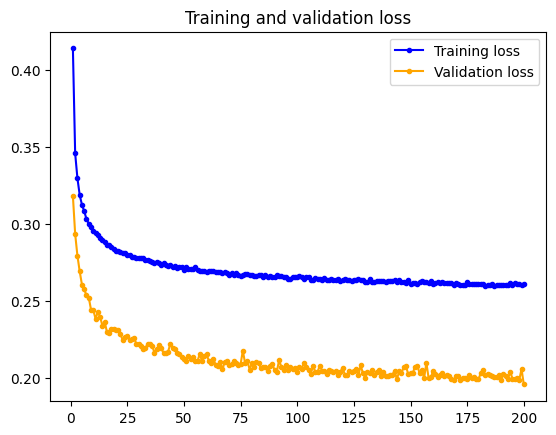

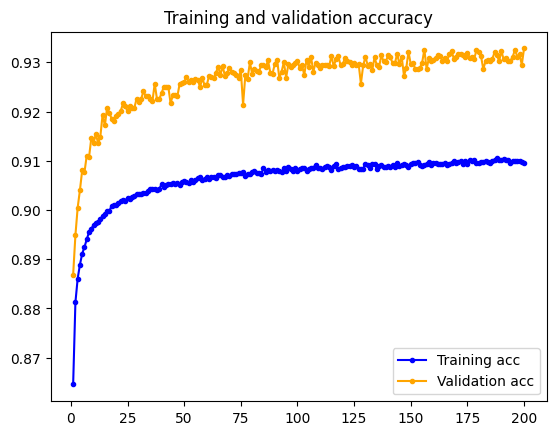

In [14]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [15]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
y_pred = model.predict(X_val)
print("Validation output shape:", y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val_trans = np.argmax(y_val, axis=1)
y_pred_trans = np.argmax(y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val_trans[:50])
print("Predicted validation labels:\t", y_pred_trans[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val_trans, y_pred_trans)
cm = np.transpose(cm)

labels = range(len(gdf['uso_suelo'].unique()))

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))
    

3698/3698 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step
Validation output shape: (118330, 11)
Actual validation labels:	 [ 2  0  9  4  2  9  5  3  9  4  1  2 10  2  7  3  9  7 10  1 10  7  9  6
  8  7  3 10 10  1  0  3 10  3  8  9  4  6 10 10  3  5  8  7  5  8  4  5
  1 10]
Predicted validation labels:	 [ 4  0  9  4  2  6  5  8  9  4  1  2 10  2  7  3  9  7 10  5 10  7  9  6
  8  7  3 10 10  1  0  3 10  3  8  9  4  6 10 10  3  5  8  7  3  8  4  5
  1 10]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)    (5)    (6)    (7)    (8)    (9)    (10)  
           0 (0):  [ 10753      0     19      3      0      7      0      0      0      7      0]
           1 (1):  [     0   8566     17      2     52   1480      0      0      0     28      4]
           2 (2):  [     0    173  10184     15     27    373     14      0      1    359     15]
           3 (3):  [     0    106     58  10688     47    263      0      0      0     89      3]
           4 (4):  [     0    285     

## Apply model to the full dataset

Predict landuse for every element

In [16]:
y_hat = model.predict(X_scaled)

2752/2752 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step


Create prediction variables

In [ ]:
category_list = ['alojamiento_temporal','baldio','comercio',
                'equipamiento','espacio_verde','habitacional',
                'industria','infraestructura','mixto','servicio',
                'sin_dato']

prefix = 'pct_smote_'

category_list = [prefix+cl for cl in category_list]
category_list

In [23]:
gdf[category_list] = y_hat
print(gdf.shape)
gdf.head(4)

(88061, 65)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,clues_primer_nivel_15min,geometry,pct_alojamiento_temporal,pct_baldio,pct_equipamiento,pct_espacio_verde,pct_infraestructura,pct_mixto,pct_servicio,pct_sin_dato
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,0.357128,"MULTIPOLYGON (((2349152.724 965335.704, 234914...",1.748608e-14,0.000011,0.000002,4.379457e-07,5.847440e-29,3.772351e-15,0.000017,0.999947
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,0.467758,"MULTIPOLYGON (((2349168.91 965335.176, 2349157...",3.732478e-13,0.000031,0.000025,2.459279e-06,1.588271e-26,1.713393e-13,0.000062,0.999730
2,2,Sin dato,18.488100,75GRMGQW+8CHQ,1412000011206018,4.482118,278416.454431,18.488100,0.000066,0.242433,...,0.498686,"MULTIPOLYGON (((2349172.107 965335.071, 234916...",1.434685e-12,0.000034,0.000064,5.869093e-06,1.738778e-25,8.745152e-13,0.000081,0.999511
3,3,Sin dato,4.936089,75GRMGQW+8GCG,1412000011206018,42.992618,278416.454431,4.936089,0.000018,8.709855,...,0.518053,"MULTIPOLYGON (((2349178.053 965334.877, 234917...",5.630012e-12,0.000045,0.000106,8.477879e-06,6.370064e-25,2.152743e-12,0.000107,0.999217


Assign data to polygons

In [17]:
gdf['pred'] = y_hat.argmax(axis=1)

### Save output

### Save data for postprocessing

In [38]:
# gdf.to_file('../../data/processed/prediccion_uso_suelo/test/tess_pred.gpkg')

### Save data for output analysis

In [18]:
gdf[['fid','uso_suelo','pred','geometry']].to_file('../../data/processed/prediccion_uso_suelo/test/tess_pred_smote.gpkg')